# Initialization

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from top2vec import Top2Vec
from datasets import load_dataset
from pathlib import Path
import pandas as pd

In [3]:
proj_dir = Path.cwd().parent
proj_dir

WindowsPath('C:/Users/ditho/work_projects/top2vec')

In [4]:
model_path = proj_dir / 'models' / 'model.pkl'

# Modeling

In [5]:
dataset = load_dataset("SetFit/20_newsgroups")
dataset['train']['text'][0]

Using custom data configuration SetFit--20_newsgroups-f9362e018b6adf67
Found cached dataset json (C:/Users/ditho/.cache/huggingface/datasets/SetFit___json/SetFit--20_newsgroups-f9362e018b6adf67/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/2 [00:00<?, ?it/s]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [6]:
if not model_path.exists():
    model = Top2Vec(documents=dataset['train']['text'],
                    speed="learn",
#                     workers=-1, 
                    embedding_model='all-MiniLM-L6-v2',
                    embedding_batch_size=4
                   )
    model._check_model_status()
    model.save(model_path)
else:
    model = Top2Vec.load(model_path)
    model._check_model_status()

In [7]:
model.document_vectors.shape

(11314, 384)

In [8]:
model.doc_top

array([ 1, 17, 26, ..., 26, 40,  1])

In [9]:
model.topic_sizes

0     1023
1      844
2      451
3      423
4      385
      ... 
59      49
60      47
61      47
62      43
63      32
Length: 64, dtype: int64

In [10]:
model.hierarchical_topic_reduction(num_topics=20)

[[0],
 [1],
 [19, 22, 24, 40, 8],
 [13, 55, 11],
 [41, 29, 52, 9],
 [27, 60, 30, 34, 37, 20],
 [62, 18, 38, 12],
 [61, 32, 45, 53, 10],
 [26, 44, 17],
 [42, 50, 51, 6],
 [57, 3],
 [63, 4],
 [39, 25, 15],
 [49, 28, 36, 56, 14],
 [2],
 [47, 21, 58, 35, 46, 31],
 [48, 5],
 [43, 16],
 [59, 33, 54, 23],
 [7]]

In [11]:
len(model.word_vectors)

3885

# UMAP

In [12]:
%%time
import umap.plot
umap_args_model = {
"n_neighbors": 10,
"n_components": 2,# -> 2 for plotting
"metric": "minkowski",
'min_dist':0.10,
'spread':1
}
umap_model = umap.UMAP(**umap_args_model).fit(model.document_vectors)

CPU times: total: 48.1 s
Wall time: 31.5 s


In [13]:
%%time
import joblib
filename = proj_dir/'models'/'umap.sav'
joblib.dump(umap_model, filename)

C:\Users\ditho\AppData\Roaming\Python\Python39\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: total: 12.1 s
Wall time: 12.7 s


['C:\\Users\\ditho\\work_projects\\top2vec\\models\\umap.sav']

In [14]:
umap_model.transform(model.embed("I love Computers!").reshape(1, -1))

array([[ 1.0132099, -0.7026323]], dtype=float32)

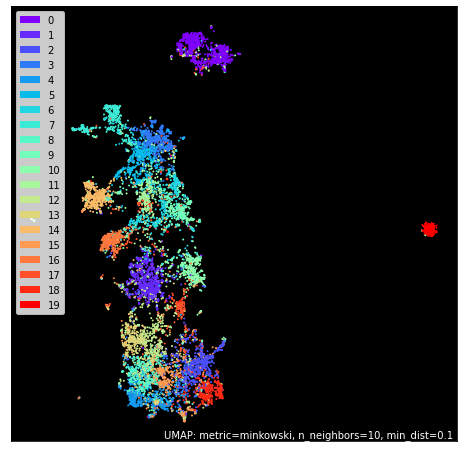

In [15]:
umap_fig2 = umap.plot.points(umap_model, labels = model.doc_top_reduced, theme='fire')

# Key BERT

In [16]:
if False:
    from keybert import KeyBERT
    from sentence_transformers import SentenceTransformer

    sentence_model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda')
    kw_model = KeyBERT(model=sentence_model)

In [17]:
if False:
    kw_model.extract_keywords(dataset['train']['text'][0],
                              keyphrase_ngram_range=(3, 3), stop_words='english',
                                  use_mmr=True, diversity=0.7)

# Get Topics

In [18]:
topics = model.get_topics(reduced=True)
rows = []
for topic, weight, topic_id in zip(topics[0], topics[1], topics[2]):
    topic_d = {f'topic_{i}':topic[i] for i in range(10)}
    weight_d = {f'weight_{i}':weight[i] for i in range(10)}
    rows.append({'topic_id':topic_id, **topic_d, **weight_d})
#     rows.append({'topic_id':topic_id, **topic_d})
topics_df = pd.DataFrame(rows)
topics_df
topics_df.to_csv(proj_dir/'data'/'topics.csv', index=False)

topic_id        topic_0      topic_1      topic_2      topic_3  \
0          0            nhl       flyers     pitching         cubs   
1          1       vehicles      vehicle  motorcycles        honda   
2          2       software       bitmap    microsoft         unix   
3          3      scripture     biblical   scriptures    testament   
4          4           disk  motherboard        disks  workstation   
5          5        atheism      beliefs       belief      atheist   
6          6  investigation         news      alleged          nra   
7          7   palestinians     israelis  palestinian         gaza   
8          8       hardware  motherboard    processor          ram   
9          9        firearm     firearms         guns          nra   
10        10           nasa   spacecraft   satellites    astronomy   
11        11          funny     whatever         said         says   
12        12           sale       prices     purchase          buy   
13        13          modem          mhz       analog        audio   
14        14       patients    treatment     diseases     clinical   
15        15            vga     monitors      monitor     displays   
16        16     encryption          nsa        crypt       crypto   
17        17           mail      contact        email      mailing   
18        18          xterm           xt          xdm  openwindows   
19        19             uh           um           so           er   

         topic_4        topic_5     topic_6    topic_7    topic_8  ...  \
0         braves         sabres       leafs    rangers       mets  ...   
1     motorcycle            bmw     dealers       cars        car  ...   
2      shareware        toolkit     formats   programs   binaries  ...   
3   christianity         gospel  christians  disciples     verses  ...   
4       hardware         floppy          os    drivers     drives  ...   
5      religious        secular    morality   atheists  religions  ...   
6       evidence       incident     victims    suspect   concerns  ...   
7        israeli      palestine      israel   genocide  armenians  ...   
8          intel            mhz        cmos       vram      specs  ...   
9        handgun    enforcement    handguns  liberties    militia  ...   
10  astronomical        orbiter     shuttle   missions      astro  ...   
11      relevant             he      readme   speaking     remark  ...   
12        buying       shipping       price       sold     offers  ...   
13   electronics          radio      signal   hardware        dsl  ...   
14      medicine        disease     medical    doctors        med  ...   
15      graphics          pixel     drivers     screen   hardware  ...   
16  cryptography  cryptographic    security  encrypted    privacy  ...   
17       address     newsletter        send    message   messages  ...   
18        libxmu            xmu      window     screen    widgets  ...   
19            ah             em        yeah         oh         hm  ...   

    weight_0  weight_1  weight_2  weight_3  weight_4  weight_5  weight_6  \
0   0.543926  0.494511  0.489982  0.487934  0.486236  0.483516  0.478826   
1   0.577940  0.562160  0.559524  0.528763  0.510132  0.494557  0.476860   
2   0.536654  0.485662  0.478990  0.476612  0.462889  0.448317  0.440578   
3   0.612005  0.571881  0.561385  0.556096  0.540397  0.511952  0.505659   
4   0.440244  0.401422  0.395387  0.387878  0.386770  0.369409  0.365550   
5   0.594171  0.517381  0.496043  0.477527  0.466389  0.465384  0.457678   
6   0.358328  0.348530  0.340339  0.338833  0.338219  0.328524  0.320860   
7   0.557075  0.547787  0.536402  0.529442  0.527833  0.504161  0.480319   
8   0.585325  0.571596  0.540033  0.511710  0.468207  0.467610  0.464198   
9   0.491917  0.463970  0.456809  0.447501  0.444435  0.443916  0.417034   
10  0.628986  0.541620  0.469068  0.429223  0.415828  0.408391  0.405889   
11  0.466377  0.452810  0.420255  0.420184  0.418860  0.415667  0.

In [19]:
import plotly.graph_objects as go

In [20]:
fig2 = go.Figure(data=[go.Table(
    header=dict(values=list(topics_df.columns),
                fill_color='darkgreen',
                align='left'),
    cells=dict(values=topics_df.T,
               fill_color='darkblue',
               align='left',
               line_color='white')
    
)])
fig2.show()

# Topic Search by Keyword

In [21]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["medicine"], num_topics=5)
pd.DataFrame({'topic_words':topic_words, 'topic_scores':topic_scores, 'word_scores':word_scores, 'topic_nums':topic_nums}).head()

topic_words  topic_scores  \
0  [patients, treatment, diseases, disease, medic...      0.421746   
1  [drugs, drug, tobacco, criminals, medicine, cr...      0.325306   
2  [uh, um, so, er, ah, yeah, em, oh, hm, he, but...      0.281698   
3  [funny, joke, remark, whatever, reported, eh, ...      0.235219   
4  [scientific, skepticism, scientists, science, ...      0.227062   

                                         word_scores  topic_nums  
0  [0.49349612, 0.4869696, 0.4417882, 0.4306956, ...           2  
1  [0.5500872, 0.52503467, 0.34861028, 0.32636768...          51  
2  [0.69431293, 0.69062114, 0.6715052, 0.6303334,...           7  
3  [0.47672042, 0.4397785, 0.42954606, 0.427966, ...           4  
4  [0.5142172, 0.45639932, 0.4371231, 0.4214431, ...          37

In [22]:
documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=["cryptography", "privacy"], num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()


Document: 6935, Score: 0.5299610183319308
-----------
Note:     The following was released by the White House today in
          conjunction with the announcement of the Clipper Chip
          encryption technology.

                           FACT SHEET

                  PUBLIC ENCRYPTION MANAGEMENT

The President has approved a directive on "Public Encryption
Management."  The directive provides for the following:

Advanced telecommunications and commercially available encryption
are part of a wave of new computer and communications technology. 
Encryption products scramble information to protect the privacy of
communications and data by preventing unauthorized access. 
Advanced telecommunications systems use digital technology to
rapidly and precisely handle a high volume of communications. 
These advanced telecommunications systems are integral to the
infrastructure needed to ensure economic competitiveness in the
information age.

Despite its benefits, new communications technolo

# Search Documents by Topic

In [23]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=48, num_docs=5)
pd.DataFrame({'document_ids':document_ids, 'documents':documents, 'document_scores':document_scores}).head()

document_ids                                          documents  \
0          2104  Archive-name: cryptography-faq/part06\nLast-mo...   
1          6950  Archive-name: cryptography-faq/part10\nLast-mo...   
2           853  Archive-name: cryptography-faq/part09\nLast-mo...   
3          1954  Archive-name: cryptography-faq/part03\nLast-mo...   
4          7007  .................................................   

   document_scores  
0         0.750314  
1         0.740330  
2         0.735426  
3         0.733275  
4         0.722942

# Search Documents by Documents

In [24]:
type(model.embed)

method

In [25]:
model._check_model_status()

In [26]:
search_text = 'This is about electronic mail'
vector = model.embed([search_text])

In [27]:
vector.flatten().shape

(384,)

In [28]:
documents, document_scores, document_ids = model.search_documents_by_vector(vector.flatten(), num_docs=5)
pd.DataFrame({'document_ids':document_ids, 'documents':documents, 'document_scores':document_scores}).head()

document_ids                                          documents  \
0          3383  \nEd, as usual, makes a very good point.\n\nOn...   
1          4633  --- Received from EEI.EEIIHY  353-1-2800455   ...   
2          2485  Please satisfy my curiosity. I'm interested in...   
3          7204  \n\nGood question. I also wanted to find out a...   
4          7014  \nI know you said E-mail preferred but because...   

   document_scores  
0         0.556424  
1         0.532769  
2         0.520099  
3         0.515784  
4         0.513503

# Search Documents by Keyword

In [29]:
documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=["cryptography", "privacy"], num_docs=5)
pd.DataFrame({'document_ids':document_ids, 'documents':documents, 'document_scores':document_scores}).head()

document_ids                                          documents  \
0          6935  Note:     The following was released by the Wh...   
1          7007  .................................................   
2          4682  Archive-name: net-privacy/part2\nLast-modified...   
3          6509  \n\n  Simple -- if you have a choice between:\...   
4          1258  What is the status of cruptology for private c...   

   document_scores  
0         0.529961  
1         0.509190  
2         0.491791  
3         0.489780  
4         0.489435

# Similar Keywords

In [30]:
words, word_scores = model.similar_words(keywords=["space"], keywords_neg=[], num_words=20)
pd.DataFrame({'word_scores': word_scores, 'words': words}).head()

word_scores       words
0     0.628185    universe
1     0.606741        nasa
2     0.597259  spacecraft
3     0.589628        room
4     0.575512       earth

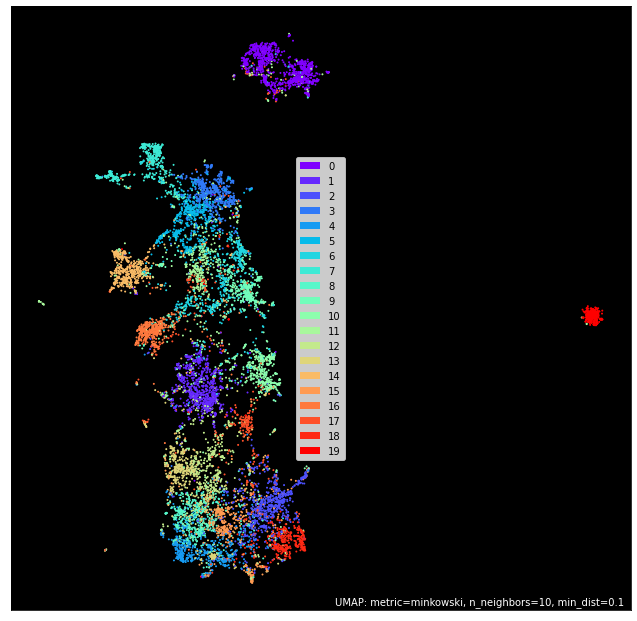

In [31]:
umap_fig2 = umap.plot.points(umap_model, labels = model.doc_top_reduced, theme='fire')

# Write Topics and Documents

In [32]:
data_df = pd.DataFrame(umap_model.embedding_, columns=['x', 'y'])
data_df['documents'] = model.documents
data_df['topic_id'] = model.doc_top_reduced
# data_df['topics_str'] = df.topics.apply(lambda x: f'{x:02d}')
data_df.index.name = 'id'
# del data_df['topics']
data_df.head()

x         y                                          documents  \
id                                                                          
0   0.212574  2.324136  I was wondering if anyone out there could enli...   
1  -1.212384 -1.934929  A fair number of brave souls who upgraded thei...   
2  -0.254687 -1.417804  well folks, my mac plus finally gave up the gh...   
3  -0.527214 -1.236323  \nDo you have Weitek's address/phone number?  ...   
4   1.988841  2.614665  From article <C5owCB.n3p@world.std.com>, by to...   

    topic_id  
id            
0          1  
1          8  
2          8  
3         13  
4          4

In [33]:
data_df.to_csv(proj_dir/'data'/'data.csv')

In [34]:
data_df.head(5).topic_id.value_counts().to_frame().merge(topics_df, left_index=True, right_on='topic_id').drop(['topic_id', 'topic_id_y'], axis=1).rename({'topic_id_x':'topic_count'}, axis=1)

topic_count   topic_0      topic_1      topic_2      topic_3      topic_4  \
8             2  hardware  motherboard    processor          ram        intel   
1             1  vehicles      vehicle  motorcycles        honda   motorcycle   
13            1     modem          mhz       analog        audio  electronics   
4             1      disk  motherboard        disks  workstation     hardware   

   topic_5  topic_6   topic_7 topic_8  ...  weight_0  weight_1  weight_2  \
8      mhz     cmos      vram   specs  ...  0.585325  0.571596  0.540033   
1      bmw  dealers      cars     car  ...  0.577940  0.562160  0.559524   
13   radio   signal  hardware     dsl  ...  0.497769  0.442074  0.441286   
4   floppy       os   drivers  drives  ...  0.440244  0.401422  0.395387   

    weight_3  weight_4  weight_5  weight_6  weight_7  weight_8  weight_9  
8   0.511710  0.468207  0.467610  0.464198  0.450995  0.440455  0.417700  
1   0.528763  0.510132  0.494557  0.476860  0.474569  0.471685  0.439867  
13  0.437606  0.435566  0.425108  0.415435  0.407329  0.398933  0.396407  
4   0.387878  0.386770  0.369409  0.365550  0.361031  0.354560  0.349896  

[4 rows x 21 columns]

## Plot Topics

In [35]:
len(model.topic_word_scores_reduced)
len(model.topic_words_reduced)

20

20

In [36]:
import plotly.graph_objects as go

In [37]:
topic_num = 5
fig = go.Figure(go.Bar(
            x=model.topic_word_scores_reduced[topic_num][::-1],
            y=model.topic_words_reduced[topic_num][::-1],
            orientation='h'))

fig.show()